# MTH8408 - Lab 2
### Simon-Mathieu Bergeron Hartman - 1993061

In [1]:
using Pkg
using LinearAlgebra
using JuMP
using Ipopt
using MathOptInterface

Pkg.activate("nlpmodels")

using ADNLPModels #Pkg.add("ADNLPModels")
using NLPModels #Pkg.add("NLPModels")
using NLPModelsJuMP #Pkg.add("NLPModelsJuMP")
using NLPModelsIpopt #Pkg.add("NLPModelsIpopt")
using JuMP
using Printf
using Test
using Plots
using LaTeXStrings

  Activating new environment at `C:\Users\smber\Desktop\Maîtrise\Cours\MTH8408\nlpmodels\Project.toml`


## Questions dans Lab2-notebook.ipynb

### Exercice 1: Newton avec recherche linéaire - amélioration du code

La fonction f(x,y) = x^2(2x-3)-6xy(x-y-1) a un maximum local en (-1,-1), un minimum local en (1,0) et deux points de selle en (0,0) et en (0,-1). On essait de retomber sur ces points lors des tests des algorithmes.

In [2]:
# Problème test:
f(x) = x[1]^2 * (2*x[1] - 3) - 6*x[1]*x[2] * (x[1] - x[2] - 1) # fonction objectif vue en classe
g(x) = 6 * [x[1]^2 - x[1] - 2*x[1]*x[2] + x[2]^2 + x[2]; -x[1]^2 + 2*x[1]*x[2] + x[1]] # le gradient de f

# Création du nlp
x0nlp = [0.5,0.5]
nlp = ADNLPModel(f,x0nlp);

Fonctions armijo() et newton_armijo() modifiées

In [3]:
function modified_armijo(xk, dk, fk, gk, nlp)
  slope = dot(gk, dk) #doit être <0
  t = 1.0
  ftest = obj(nlp, xk + t * dk)
  while ftest > fk + 1.0e-4 * t * slope
    t /= 1.5
    ftest = obj(nlp, xk + t * dk)
  end
  fk = ftest
  return t,fk
end

modified_armijo (generic function with 1 method)

In [4]:
function modified_newton_armijo(nlp,x0; verbose::Bool = true)

  t0 = time()  
  xk  = x0
  fk  = obj(nlp,xk)
  gk = grad(nlp,xk)
  gnorm = gnorm0 = norm(gk)
  k = 0
  iterations = x0 #Stockage des xk
    
  verbose && @printf "%2s %9s %9s\n" "k" "fk" "||∇f(x)||"
  verbose && @printf "%2d %9.2e %9.1e\n" k fk gnorm
    
  while gnorm > 1.0e-6 + 1.0e-6 * gnorm0 && k < 100

    #Vérification des conditions d'arrêt
    if fk < -1e15
        @printf "Fonction non-bornée inférieurement\n"
        break
    elseif neval_obj(nlp) > 1000
        @printf "Nombre maximal d'évaluation de la fonction objet atteint\n"
        break
    elseif time() - t0 > 60
        @printf "Temps maximal d'exécution atteint\n"
        break
    end
        
    #Choix de dk    
    Hk = hess(nlp,xk)
    dk = - Hk \ gk
    slope = dot(dk, gk)
    λ = 0.0
    maj = 0  #compteur de mise-à-jour de \lambda
        
    while slope ≥ -1.0e-4 * norm(dk) * gnorm && maj<5
      λ = max(1.0e-3, 10 * λ)
      dk = - ((Hk + λ * I ) \ gk)
      slope = dot(dk, gk)
    end
    if maj == 5
        dk = -gk
        #@printf "5 maj"
    end

    #armijo
    t,fk = modified_armijo(xk, dk, fk, gk, nlp)
    xk += t * dk
    #fk  = obj(nlp,xk)
    gk = grad(nlp,xk)
    gnorm = norm(gk)
    k += 1
    verbose && @printf "%2d %9.2e %9.1e %7.1e \n" k fk gnorm t
    iterations = hcat(iterations, xk)
  end

  @printf "Nombre d'évaluations: %9.3d\n" neval_obj(nlp)
  @printf "Valeur minimale de f: %9.8e\n" obj(nlp,xk)
  @printf "Temps d'exécution: %9.8e\n" time()-t0
  return xk, iterations
    
end

modified_newton_armijo (generic function with 1 method)

In [5]:
#Objectif: retrouver le point de selle en (0,0)
x0 = [0.5, 0.5]
nlp = ADNLPModel(f, x0)

sol, iterations = modified_newton_armijo(nlp, x0)
test = @test grad(nlp,sol) ≈ zeros(2) atol = 1.0e-6
println("Solution: ",sol)
println("Test: ",test)

 k        fk ||∇f(x)||
 0  1.00e+00   4.5e+00
 1  5.08e-02   8.4e-01 1.0e+00 
 2  4.73e-04   7.6e-02 1.0e+00 
 3  6.97e-08   9.1e-04 1.0e+00 
 4  1.62e-15   1.4e-07 1.0e+00 
Nombre d'évaluations:       005
Valeur minimale de f: 1.61897868e-15
Temps d'exécution: 2.08740001e+01
Solution: [2.323057366509693e-8, 2.323057366509693e-8]
Test: Test Passed


In [6]:
#Objectif: retrouver le minimum en (1,0)
x0 = [2.0,0.0]
nlp = ADNLPModel(f, x0)

sol, iterations = modified_newton_armijo(nlp, x0)
test = @test grad(nlp,sol) ≈ zeros(2) atol = 1.0e-6
println("Solution: ",sol)
println("Test: ",test)

 k        fk ||∇f(x)||
 0  4.00e+00   1.7e+01
 1 -5.93e-01   3.8e+00 1.0e+00 
 2 -9.86e-01   6.0e-01 1.0e+00 
 3 -1.00e+00   3.3e-02 1.0e+00 
 4 -1.00e+00   1.3e-04 1.0e+00 
 5 -1.00e+00   2.0e-09 1.0e+00 
Nombre d'évaluations:       006
Valeur minimale de f: -1.00000000e+00
Temps d'exécution: 4.29999828e-02
Solution: [1.0000000002328306, 6.434514018248865e-17]
Test: Test Passed


### Exercice 2: LDLt-Newton avec recherche linéaire

In [7]:
using LDLFactorizations, LinearAlgebra

In [8]:
"""
    newton_ldlt_armijo(nlp, x0, choix; verbose::Bool = true)
        nlp: modèle nlp à optimiser
        x0: essaie initial
        choix: choix de la méthode de correction de la matrice hessienne

Fonction qui utilise la méthode de Newton avec une factorisation LDL de la matrice hessienne pour trouver dk.
Si H n'est pas déf. pos., la variable choix détermine la méthode de correction utilisée et prend une valeur de 1 ou 2.
Si choix = 1, on prend la valeur absolu de D de la décomposition LDL de H. Si choix = 2, on applique Dij = -min(Dii) + 1e-6,
avec i et j les indices des éléments de D.
"""

function newton_ldlt_armijo(nlp, x0, choix; verbose::Bool = true)

  t0 = time()
  xk  = x0
  fk  = obj(nlp, xk)
  gk = grad(nlp, xk)
  gnorm = gnorm0 = norm(gk)
  k = 0
  iterations = x0 #Stockages des xk
    
  verbose && @printf "%2s %9s %9s\n" "k" "fk" "||∇f(x)||"
  verbose && @printf "%2d %9.2e %9.1e\n" k fk gnorm
    
  while gnorm > 1.0e-6 + 1.0e-6 * gnorm0 && k < 100 && fk > -1e15

    #Vérification des conditions d'arrêt
    if fk < -1e15
        @printf "Fonction non-bornée inférieurement\n"
        break
    elseif neval_obj(nlp) > 1000
        @printf "Nombre maximal d'évaluation de la fonction objet atteint\n"
        break
    elseif time() - t0 > 60
        @printf "Temps maximal d'exécution atteint\n"
        break
    end
        
    Hk = Symmetric(triu(hess(nlp, xk)), :U)
    Sk = ldl_analyze(Hk)
    ldl_factorize!(Hk,Sk)

    #Correction de la matrice D de la factorisation LDL
    if minimum(Sk.d) <= 0 && choix == 1
        Sk.d = abs.(Sk.d)
    elseif minimum(Sk.d) <= 0 && choix == 2
        Sk.d .+= -minimum(Sk.d) + 1e-6
    end
            
    dk = - Sk \ gk
    slope = dot(dk, gk)
    t,fk = modified_armijo(xk, dk, fk, gk, nlp)
    xk += t * dk
    gk = grad(nlp, xk)
    gnorm = norm(gk)
    k += 1
    verbose && @printf "%2d %9.2e %9.1e %7.1e \n" k fk gnorm t
    iterations = hcat(iterations, xk)
  end
    
  @printf "Nombre d'évaluations: %9.3d\n" neval_obj(nlp)
  @printf "Valeur minimale de f: %9.8e\n" obj(nlp,xk)
  @printf "Temps d'exécution: %9.8e\n" time()-t0
  return xk, iterations
end

newton_ldlt_armijo (generic function with 1 method)

In [9]:
#Test
choix = 1
x0 = [1.5,0.5]
nlp = ADNLPModel(f, x0)
sol, iterations = newton_ldlt_armijo(nlp, x0, choix)
println("Solution: ",sol)

 k        fk ||∇f(x)||
 0  0.00e+00   4.5e+00
 1 -9.49e-01   8.4e-01 1.0e+00 
 2 -1.00e+00   7.6e-02 1.0e+00 
 3 -1.00e+00   9.1e-04 1.0e+00 
 4 -1.00e+00   1.4e-07 1.0e+00 
Nombre d'évaluations:       005
Valeur minimale de f: -1.00000000e+00
Temps d'exécution: 2.98500013e+00
Solution: [1.0000000232305737, 2.3230573678432618e-8]


In [10]:
#Test
x0 = -1*[0.9,0.9]
nlp = ADNLPModel(f, x0)
choix = 2
sol, iterations = newton_ldlt_armijo(nlp, x0, choix)
test = @test g(sol) ≈ zeros(2) atol = 1.0e-6
println("Solution: ",sol)
println("Test: ",test)

 k        fk ||∇f(x)||
 0  9.72e-01   5.4e-01
 1  4.25e-01   1.5e+00 1.0e+00 
 2  1.29e-01   1.0e+00 1.0e+00 
 3  3.51e-02   6.0e-01 1.0e+00 
 4  9.11e-03   3.0e-01 1.0e+00 
 5 -3.01e-01   5.3e+00 8.9e-05 
 6 -9.70e-01   8.9e-01 1.0e+00 
 7 -1.00e+00   6.7e-02 1.0e+00 
 8 -1.00e+00   5.2e-04 1.0e+00 
 9 -1.00e+00   3.2e-08 1.0e+00 
Nombre d'évaluations:       033
Valeur minimale de f: -1.00000000e+00
Temps d'exécution: 3.14999819e-01
Solution: [1.0000000037571324, 6.63699858932015e-17]
Test: Test Passed


### Exercice 3: Méthode quasi-Newton: BFGS

In [11]:
function bfgs_quasi_newton_armijo(nlp, x0; verbose::Bool = true)

  t0 = time()  
  xk  = x0
  fk  = obj(nlp,xk)
  gk = grad(nlp,xk)
  gnorm = gnorm0 = norm(gk)
  k = 0
  skip = 0 #Compte les skips
  Hk = I(nlp.meta.nvar)
  sk = zeros(nlp.meta.nvar)
  yk = zeros(nlp.meta.nvar)
  iterations = x0  #Stockage des coordonnées des xk
  

  verbose && @printf "%2s %9s %9s\n" "k" "fk" "||∇f(x)||"
  verbose && @printf "%2d %9.2e %9.1e\n" k fk gnorm
    
  while gnorm > 1.0e-6 + 1.0e-6 * gnorm0 && k < 100

    #Vérification des conditions d'arrêt
    if fk < -1e15
        @printf "Fonction non-bornée inférieurement\n"
        break
    elseif neval_obj(nlp) > 1000
        @printf "Nombre maximal d'évaluation de la fonction objet atteint\n"
        break
    elseif time() - t0 > 60
        @printf "Temps maximal d'exécution atteint\n"
        break
    end

    dk = -Hk*gk   
        
    #armijo
    t,fk = modified_armijo(xk, dk, fk, gk, nlp)

    #Mise à jour des paramètres
    xk1 = xk + t * dk
    sk = xk1 - xk
    
    gk1 = grad(nlp,xk1)
    yk = gk1 - gk

    #Met Hk à jour si dot(yk,sk) est plus grand que 0
    if dot(yk,sk)>0
            
        if k==0
            Hk = ( dot(yk,sk)/dot(yk,yk) )*I(nlp.meta.nvar)
            @printf "done\n"
        end

        rhok = 1/dot(yk,sk)
        Hk = (I(nlp.meta.nvar) - rhok*sk*transpose(yk)) * Hk * (I(nlp.meta.nvar) - rhok*yk*transpose(sk)) + rhok*sk*transpose(sk)

        skip = skip-1
        @printf "Update done\n"
    end

    xk = xk1
    gk = gk1
    gnorm = norm(gk)
    k += 1
    skip += 1
    verbose && @printf "%2d %9.2e %9.1e %7.1e \n" k fk gnorm t
    iterations = hcat(iterations, xk)
  end

  @printf "Nombre d'évaluations: %9.3d\n" neval_obj(nlp)
  @printf "Valeur minimale de f: %9.8e\n" obj(nlp,xk)
  @printf "Temps d'exécution: %9.8e\n" time()-t0
  return xk, iterations, skip
    
end

bfgs_quasi_newton_armijo (generic function with 1 method)

In [12]:
x0 = [1.5,0.5]
nlp = ADNLPModel(f, x0)
sol, iterations, skip = bfgs_quasi_newton_armijo(nlp, x0)
println("Solution: ",sol)
println("Skips: ",skip)

 k        fk ||∇f(x)||
 0  0.00e+00   4.5e+00
done
Update done
 1 -3.73e-01   4.2e+00 8.8e-02 
Update done
 2 -7.22e-01   1.4e+00 1.0e+00 
Update done
 3 -8.44e-01   9.3e-01 1.0e+00 
Update done
 4 -9.83e-01   4.6e-01 1.0e+00 
Update done
 5 -9.98e-01   2.3e-01 1.0e+00 
Update done
 6 -1.00e+00   7.9e-02 1.0e+00 
Update done
 7 -1.00e+00   1.3e-02 1.0e+00 
Update done
 8 -1.00e+00   9.1e-04 1.0e+00 
Update done
 9 -1.00e+00   1.3e-04 1.0e+00 
Update done
10 -1.00e+00   6.7e-06 1.0e+00 
Update done
11 -1.00e+00   1.1e-07 1.0e+00 
Nombre d'évaluations:       018
Valeur minimale de f: -1.00000000e+00
Temps d'exécution: 6.19400001e+00
Solution: [1.0000000149131603, 1.5213298820081882e-9]
Skips: 0


### Exercice 4: application à un problème de grande taille

In [13]:
using ADNLPModels, OptimizationProblems.ADNLPProblems
using OptimizationProblems

In [14]:
n = 8
nlpGen = genrose(n=n);
nlpWoods = woods(n=n);

println(@test unconstrained(nlpGen))
println(@test unconstrained(nlpWoods))

Test Passed
Test Passed


#### Résolution avec modified_newton_armijo()

In [15]:
#Genrose
x0 = 0.6*ones(n)
sol, iterations = modified_newton_armijo(nlpGen, x0);
println("sol: ", sol)

 k        fk ||∇f(x)||
 0  4.24e+01   8.0e+01
 1  6.43e+00   7.7e+01 6.7e-01 
 2  1.26e+00   8.6e+00 1.0e+00 
 3  1.25e+00   1.5e+01 1.0e+00 
 4  1.02e+00   2.3e-01 1.0e+00 
 5  1.02e+00   6.0e+00 1.0e+00 
 6  1.00e+00   1.6e-02 1.0e+00 
 7  1.00e+00   2.5e-02 1.0e+00 
 8  1.00e+00   4.0e-07 1.0e+00 
Nombre d'évaluations:       010
Valeur minimale de f: 1.00000000e+00
Temps d'exécution: 1.03290000e+01
sol: [0.9999999960255136, 0.9999999920311542, 0.9999999840125262, 0.999999967920227, 0.9999999356278129, 0.9999998708307324, 0.9999997408587871, 0.9999994809333485]


In [16]:
#Woods
x0 = 0.5*ones(n)
sol, iterations = modified_newton_armijo(nlpWoods, x0);
println("sol: ", sol)

 k        fk ||∇f(x)||
 0  4.48e+01   1.1e+02
 1  1.80e+01   1.2e+02 1.0e+00 
 2  3.23e-01   5.6e+00 1.0e+00 
 3  5.51e-03   2.0e+00 1.0e+00 
 4  1.50e-04   3.2e-01 1.0e+00 
 5  2.04e-07   1.1e-02 1.0e+00 
 6  4.18e-13   1.7e-05 1.0e+00 
Nombre d'évaluations:       007
Valeur minimale de f: 4.17754151e-13
Temps d'exécution: 8.85200000e+00
sol: [1.0000002018994563, 1.000000381125231, 0.99999982011196, 0.9999996230003663, 1.0000002018994563, 1.000000381125231, 0.99999982011196, 0.9999996230003663]


#### Résolution avec newton_ldlt_armijo(nlp, x0, choix)

In [17]:
#Genrose
choix = 1
x0 = 0.9*ones(n)
sol, iterations= newton_ldlt_armijo(nlpGen, x0, choix);
println("sol: ", sol)

 k        fk ||∇f(x)||
 0  6.74e+00   5.2e+01
 1  3.97e+00   4.8e+01 8.8e-02 
 2  1.35e+00   1.2e+01 1.0e+00 
 3  1.07e+00   1.3e+00 1.0e+00 
 4  1.04e+00   5.8e+00 1.0e+00 
 5  1.01e+00   1.8e-01 1.0e+00 
 6  1.00e+00   1.6e+00 1.0e+00 
 7  1.00e+00   5.8e-03 1.0e+00 
 8  1.00e+00   4.4e-03 1.0e+00 
 9  1.00e+00   5.8e-08 1.0e+00 
Nombre d'évaluations:       027
Valeur minimale de f: 1.00000000e+00
Temps d'exécution: 8.18000078e-01
sol: [0.9999999995803587, 0.9999999991585918, 0.9999999983118182, 0.9999999966121291, 0.9999999932000349, 0.9999999863479478, 0.9999999725792753, 0.999999944899592]


In [18]:
#Woods
choix = 1
x0 = 0.9*ones(n)
sol, iterations = newton_ldlt_armijo(nlpWoods, x0, choix);
println("sol: ", sol)

 k        fk ||∇f(x)||
 0  3.92e+00   6.7e+01
 1  8.47e-01   3.4e+01 4.4e-01 
 2  1.04e-01   1.3e+01 1.0e+00 
 3  6.55e-04   3.4e-01 1.0e+00 
 4  2.84e-06   6.4e-02 1.0e+00 
 5  4.50e-11   8.6e-05 1.0e+00 
 6  1.70e-20   4.9e-09 1.0e+00 
Nombre d'évaluations:       017
Valeur minimale de f: 1.70020397e-20
Temps d'exécution: 4.99999523e-02
sol: [0.9999999999791291, 0.9999999999528116, 1.0000000000269913, 1.0000000000477778, 0.9999999999791291, 0.9999999999528116, 1.0000000000269913, 1.0000000000477778]


#### Résolution avec bfgs_quasi_newton_armijo(nlp, x0)

In [19]:
#Genrose
x0 = 0.9*ones(n)
#nlp = ADNLPModel(f, x0)
sol, iterations = bfgs_quasi_newton_armijo(nlpGen, x0);
println("sol: ", sol)

 k        fk ||∇f(x)||
 0  6.74e+00   5.2e+01
done
Update done
 1  6.06e+00   1.1e+02 5.1e-03 
Update done
 2  1.40e+00   2.4e+01 1.0e+00 
Update done
 3  1.11e+00   1.5e+01 1.0e+00 
Update done
 4  1.03e+00   6.6e+00 1.0e+00 
Update done
 5  1.01e+00   1.6e+00 1.0e+00 
Update done
 6  1.01e+00   5.2e-01 1.0e+00 
Update done
 7  1.01e+00   3.4e-01 1.0e+00 
Update done
 8  1.01e+00   1.1e-01 1.0e+00 
Update done
 9  1.01e+00   1.1e-01 1.0e+00 
Update done
10  1.01e+00   3.0e-01 1.0e+00 
Update done
11  1.01e+00   6.4e-01 1.0e+00 
Update done
12  1.01e+00   1.1e+00 1.0e+00 
Update done
13  1.01e+00   1.6e+00 1.0e+00 
Update done
14  1.00e+00   1.8e+00 1.0e+00 
Update done
15  1.00e+00   9.5e-01 1.0e+00 
Update done
16  1.00e+00   3.1e-01 1.0e+00 
Update done
17  1.00e+00   8.2e-02 1.0e+00 
Update done
18  1.00e+00   3.9e-02 1.0e+00 
Update done
19  1.00e+00   2.8e-02 1.0e+00 
Update done
20  1.00e+00   9.7e-03 1.0e+00 
Update done
21  1.00e+00   1.5e-03 1.0e+00 
Update done
22  1.00e+00 

In [20]:
#Woods
x0 = 0.9*ones(n)
nlp = ADNLPModel(f, x0)
sol, iterations = bfgs_quasi_newton_armijo(nlpWoods, x0);
println("sol: ", sol)

 k        fk ||∇f(x)||
 0  3.92e+00   6.7e+01
done
Update done
 1  3.40e+00   6.7e+01 2.3e-03 
Update done
 2  1.04e+00   8.3e+00 1.0e+00 
Update done
 3  9.60e-01   7.8e+00 1.0e+00 
Update done
 4  2.38e-01   1.5e+01 1.0e+00 
Update done
 5  5.84e-02   9.0e+00 1.0e+00 
Update done
 6  1.05e-05   9.1e-02 1.0e+00 
Update done
 7  9.04e-08   1.6e-03 1.0e+00 
Update done
 8  8.70e-08   3.7e-04 1.0e+00 
Update done
 9  8.69e-08   3.5e-04 1.0e+00 
Update done
10  8.46e-08   9.8e-04 1.0e+00 
Update done
11  8.05e-08   1.9e-03 1.0e+00 
Update done
12  6.97e-08   3.5e-03 1.0e+00 
Update done
13  4.96e-08   4.8e-03 1.0e+00 
Update done
14  2.26e-08   4.7e-03 1.0e+00 
Update done
15  4.84e-09   2.5e-03 1.0e+00 
Update done
16  3.56e-10   5.2e-04 1.0e+00 
Update done
17  7.80e-12   1.7e-05 1.0e+00 
Nombre d'évaluations:       051
Valeur minimale de f: 7.79530679e-12
Temps d'exécution: 4.84999895e-01
sol: [1.000001037972987, 1.0000020813258084, 0.9999990019644592, 0.99999796982394, 1.0000010379730

## Questions de l'énoncé du lab 2

### Exercice 1: Méthode quasi-Newton BFGS quadratique convexe

#### 1. En partant de votre fonction BFGS codé pendant le lab (à finir), écrire une méthode adapté au cas quadratique convexe.

In [21]:
function bfgs_quadratique(nlp,x0,A; verbose::Bool = true)

  t0 = time()  
  xk  = x0
  fk  = obj(nlp,xk)
  gk = grad(nlp,xk)
  gnorm = gnorm0 = norm(gk)
  k = 0
  Hk = I(nlp.meta.nvar)
  sk = zeros(nlp.meta.nvar)
  yk = zeros(nlp.meta.nvar)
  

  verbose && @printf "%2s %9s %9s\n" "k" "fk" "||∇f(x)||"
  verbose && @printf "%2d %9.2e %9.1e\n" k fk gnorm
    
  while gnorm > 1.0e-6 + 1.0e-6 * gnorm0 && k < 100

    #Vérification des conditions d'arrêt
    if fk < -1e15
        @printf "Fonction non-bornée inférieurement\n"
        break
    elseif neval_obj(nlp) > 1000
        @printf "Nombre maximal d'évaluation de la fonction objet atteint\n"
        break
    elseif time() - t0 > 60
        @printf "Temps maximal d'exécution atteint\n"
        break
    end

    dk = -Hk*gk   

    #Calcul de alpha
    alpha = -dot(gk,dk)/(transpose(dk)*A*dk)

    #Mise à jour des paramètres
    xk1 = xk + alpha*dk
    sk = xk1 - xk
    
    gk1 = grad(nlp,xk1)
    yk = gk1 - gk

    #Met Hk à jour si dot(yk,sk) est plus grand que 0
    if dot(yk,sk)>0
            
        if k==0
            Hk = ( dot(yk,sk)/dot(yk,yk) )*I(nlp.meta.nvar)
            @printf "done\n"
        end

        rhok = 1/dot(yk,sk)
        Hk = (I(nlp.meta.nvar) - rhok*sk*transpose(yk)) * Hk * (I(nlp.meta.nvar) - rhok*yk*transpose(sk)) + rhok*sk*transpose(sk)
            
    end

    #Paramètres pour la prochaine itération
    xk = xk1
    gk = gk1
    fk = obj(nlp,xk)
    gnorm = norm(gk)
    k += 1
    verbose && @printf "%2d %9.2e %9.1e %7.1e \n" k fk gnorm alpha
  end

  @printf "Nombre d'évaluations: %9.3d\n" neval_obj(nlp)
  @printf "Valeur minimale de f: %9.8e\n" obj(nlp,xk)
  @printf "Temps d'exécution: %9.8e\n" time()-t0
  return xk
    
end

bfgs_quadratique (generic function with 1 method)

#### 2. Vérifier votre fonction sur le test suivant :

In [22]:
#Paramètres de f et test
m = 10
A = diagm(-1 => ones(m-1), 0 => 4*ones(m), 1 => ones(m-1))
b = A * [1:m;]
x0 = 0.9*ones(m)

fquad(x) = 0.5*transpose(x)*A*x - transpose(b)*x
nlpQuad = ADNLPModel(fquad,x0)

sol, iterations = bfgs_quadratique(nlpQuad, x0, A);
println("sol: ", sol)

 k        fk ||∇f(x)||
 0 -2.64e+02   9.8e+01
done
 1 -1.10e+03   6.0e+00 1.7e-01 
 2 -1.10e+03   1.3e+00 1.3e+00 
 3 -1.10e+03   3.2e-01 1.5e+00 
 4 -1.10e+03   8.6e-02 1.5e+00 
 5 -1.10e+03   2.2e-02 1.6e+00 
 6 -1.10e+03   6.0e-03 1.7e+00 
 7 -1.10e+03   1.4e-03 1.6e+00 
 8 -1.10e+03   3.3e-04 1.6e+00 
 9 -1.10e+03   6.5e-05 1.7e+00 
Nombre d'évaluations:       010
Valeur minimale de f: -1.10000000e+03
Temps d'exécution: 8.94899988e+00
sol: 1.0000167834085212


#### 3. Justifier pourquoi α est toujours bien défini théoriquement, i.e. dT Ad > 0 ?

La réponse rapide est que puisque \\(A\\) est définie positive par définition, on sait que le produit \\(x^TAx\\) sera plus grand que 0. Ceci implique que \\(d^TAd>0\\) pour tout \\(d  \in \Re^n \backslash \{ 0\}\\).

On peut aussi développer l'expression de \\(\alpha\\) et retomber sur un résultat similaire.

$$d^TAd$$

$$=(H_k \cdot (-\nabla f))^T  A  (H_k \cdot (-\nabla f))$$

$$=\nabla f^T H_k^TAH_k \nabla f$$

avec le produit \\(H_k^TAH_k\\) qui donne une matrice définie positive (disons \\(M\\)). On a donc \\(\nabla f^T M \nabla f > 0\\) et \\(\alpha\\) est bien défini i.e. n'est jamais une division par 0. Pour aller plus loin, on peut aussi développer \\(d_k\\) au numérateur et on retrouve:

$$\alpha = \frac{\nabla f^T H_k \nabla f}{\nabla f^T M \nabla f}$$

ce qui donne un numérateur et un dénominateur positifs, donc \\(\alpha\\) positif. Ceci implique que \\(x_{k+1} = x_k + \alpha d_k\\) effectue bel et bien une descente par rapport à \\(x_k\\).

### Exercice 2 : Etude de convergence

On veut évaluer la convergence de nos méthodes d'optimisation en fonction du nombre d'itérations. On utilise la fonction de Himmelbau pour faire nos tests, qui a les quatres minimums locaux \\(f(3,2)=0\\), \\(f(-2.805118, 3.131312)=0\\), \\(f(-3.779310, -3.283186)=0\\) et \\(f(3.584428, -1.848126)=0\\) (donner sur wikipedia).

In [23]:
"""
    distance(iterations)
        iterations: matrice de taille n x K avec n le nombre de dimensions et K le nombre d'itérations qui contient les 
        points xk utilisés lors d'une optimisation

La fonction effectue le calcule ||xk - xf|| des xk avec k=0:K-1 et retourne un vecteur de taille 1 x (K-1) avec les résultats
"""

function distance(iterations)
    distances = Any[]
    nbPts = size(iterations)[2] # nombres de points xk incluant xfinal
    xf = iterations[:,nbPts] # point final

    #Calcul des distances
    for i in 1:nbPts-1
        distances  = push!(distances, norm(xf-iterations[:,i]))
    end

    return 1:nbPts-1, distances #Vecteur numérotant les itérations, vecteurs des distances entre les pts xk et xf
end

"""
    convergenceLin(iterations)
        iterations: matrice de taille n x K avec n le nombre de dimensions et K le nombre d'itérations qui contient les 
        points xk utilisés lors d'une optimisation

La fonction effectue le calcule ||xk1 - xf||/||xk - xf|| des xk avec k=0:K-1 et retourne un vecteur de taille 1 x (K-1) avec les résultats
"""

function convergenceLin(iterations)
    convergence = Any[]
    nbPts = size(iterations)[2] # nombres de points xk incluant xfinal
    xf = iterations[:,nbPts] # point final

    #Calcul de la convergence
    for i in 1:nbPts-2
        xk1 = iterations[:,i+1]
        xk = iterations[:,i]
        convergence = push!(convergence, norm(xk1-xf)/norm(xk-xf))
    end

    return 1:nbPts-2, convergence #Vecteur numérotant les itérations, vecteur avec les valeurs de convergence
end

"""
    convergenceLin(iterations)
        iterations: matrice de taille n x K avec n le nombre de dimensions et K le nombre d'itérations qui contient les 
        points xk utilisés lors d'une optimisation

La fonction effectue le calcule ||xk1 - xf||/||xk - xf||^2 des xk avec k=0:K-1 et retourne un vecteur de taille 1 x (K-1) avec les résultats
"""

function convergenceQuad(iterations)
    convergence = Any[]
    nbPts = size(iterations)[2] # nombres de points xk incluant xfinal
    xf = iterations[:,nbPts] # point final

    #Calcul de la convergence
    for i in 1:nbPts-2
        xk1 = iterations[:,i+1]
        xk = iterations[:,i]
        convergence = push!(convergence, norm(xk1-xf)/(norm(xk-xf))^2)
    end

    return 1:nbPts-2, convergence #Vecteur numérotant les itérations, vecteur avec les valeurs de convergence
end

convergenceQuad (generic function with 1 method)

In [24]:
#Définition de la fonction de Himmerlblau
x0 = [10.0, 10.0]
fH(x) = (x[2]+x[1].^2-11).^2+(x[1]+x[2].^2-7).^2
nlph = ADNLPModel(fH, x0);

#Minimisation
solNM, iterationsNM = modified_newton_armijo(nlph,x0) #Résolution avec Newton modifié
solLDL, iterationsLDL = newton_ldlt_armijo(nlph, x0, 1) #Newton modifié avec factorisation LDL et correction avec D=abs(D)
solBFGS, iterationsBFGS, skip = bfgs_quasi_newton_armijo(nlph, x0) #Résolution avec BFGS
println("Skips: ",skip)
println("\n")
println("solNM: ", solNM)
println("solLDL: ", solLDL)
println("solBFGS: ", solBFGS)

 k        fk ||∇f(x)||
 0  2.04e+04   6.0e+03
 1  3.64e+03   1.7e+03 1.0e+00 
 2  5.69e+02   4.9e+02 1.0e+00 
 3  6.66e+01   1.2e+02 1.0e+00 
 4  4.57e+00   2.5e+01 1.0e+00 
 5  1.64e-01   3.4e+00 1.0e+00 
 6  8.22e-04   2.3e-01 1.0e+00 
 7  2.82e-08   1.3e-03 1.0e+00 
Nombre d'évaluations:       008
Valeur minimale de f: 2.81666466e-08
Temps d'exécution: 2.80900002e+00
 k        fk ||∇f(x)||
 0  2.04e+04   6.0e+03
 1  3.64e+03   1.7e+03 1.0e+00 
 2  5.69e+02   4.9e+02 1.0e+00 
 3  6.66e+01   1.2e+02 1.0e+00 
 4  4.57e+00   2.5e+01 1.0e+00 
 5  1.64e-01   3.4e+00 1.0e+00 
 6  8.22e-04   2.3e-01 1.0e+00 
 7  2.82e-08   1.3e-03 1.0e+00 
Nombre d'évaluations:       017
Valeur minimale de f: 2.81666466e-08
Temps d'exécution: 4.90000248e-02
 k        fk ||∇f(x)||
 0  2.04e+04   6.0e+03
done
Update done
 1  1.43e+02   2.2e+02 3.4e-03 
Update done
 2  3.63e+01   9.0e+01 1.0e+00 
Update done
 3  6.28e+00   3.3e+01 1.0e+00 
Update done
 4  5.47e-01   9.6e+00 1.0e+00 
Update done
 5  3.25e-02   

#### Affichage des valeurs de \\(x_k\\) obtenues

In [25]:
#Valeurs de xk avec Newton modifié
iterationsNM

2×8 Matrix{Float64}:
 10.0  6.74574  4.7041   3.53899  3.04212  2.97785  2.99831  2.99999
 10.0  6.65761  4.50613  3.18274  2.44486  2.10395  2.00755  2.00004

In [26]:
#Valeurs de xk avec Newton LDL
iterationsLDL

2×8 Matrix{Float64}:
 10.0  6.74574  4.7041   3.53899  3.04212  2.97785  2.99831  2.99999
 10.0  6.65761  4.50613  3.18274  2.44486  2.10395  2.00755  2.00004

In [27]:
#Valeurs de xk avec Newton BFGS
iterationsBFGS

2×11 Matrix{Float64}:
 10.0  -4.27058  -4.20688  -4.01802  …  -3.77893  -3.77923  -3.77931
 10.0  -4.79125  -4.0779   -3.60479     -3.28243  -3.28313  -3.28319

#### Graphique de distance

D'abord, on réalise que les méthode de Newton modifiée et avec factorisation LDL retrouve les mêmes valeurs de \\(x_k\\). Ceci est normale puisque la seule différence entre les méthodes sont les corrections apportées à la matrice hessienne, i.e. s'il n'y a pas de corrections, les résultats sont identiques. Avec ce graphique, on peut confirmer que \\(x_k\\) converge de façon superlinéaire.

Avec la méthode quasi-Newton, il semble y avoir plusieurs segments qui convergent à un rythme superlinéaire mais non-continu entre eux. Les segments que j'identifie sont \\(k=1,2\\), \\(k=2,3,4,5,6\\) et \\(k=6,7,8,9,10\\). On pourrait penser que les cassures dans la courbe sont dues à des itérations sans mise-à-jour de la matrice \\(H_k\\), mais ce n'est pas le cas (voir résultats de la cellule avec minimisation de la fonction de Himmelblau, \\(H_k\\) est mise-à-jour à chaque itération). Sachant ceci, une explication serait qu'il faudrait plus d'itérations (essai initial différent ou tolérance sur le gradient plus stricte) pour observer un comportement de convergence stable, ce qui pourrait revenir à dire que \\(x_0\\) commence à l'extérieur de la région \\(\mathcal{L}_0\\) du minimum trouvé. Ceci est cohérent avec nos résultats puisque la méthode BFGS trouve un minimum différent des deux autres méthodes. On pourrait imaginer que le parcours est passé proche de plusieurs minimums.

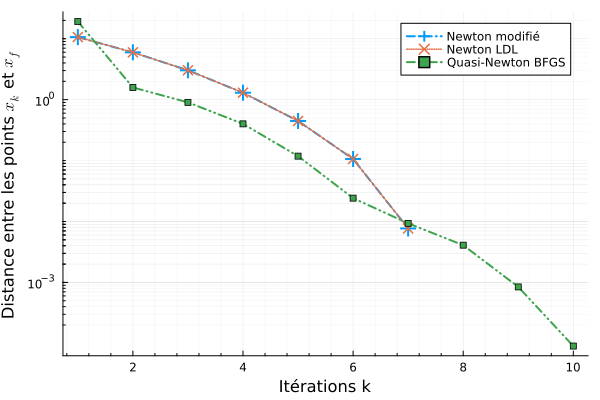

In [28]:
xNM, yNM = distance(iterationsNM)
xLDL, yLDL = distance(iterationsLDL)
xBFGS, yBFGS = distance(iterationsBFGS)

# Plot with lines and markers for each dataset
plot(xNM, yNM, label="Newton modifié", marker=(8,:cross), line=(2,:dashdot))
plot!(xLDL, yLDL, label="Newton LDL", marker=(5,:x), line=(1.5,:dot))
plot!(xBFGS, yBFGS, label="Quasi-Newton BFGS", marker=(3,:square), line=(2,:auto))

# Other plot settings
plot!( yscale=:log10, minorgrid=true)
xlabel!("Itérations k")
ylabel!(L"Distance entre les points $x_k$ et $x_f$")

#### Graphique de convergence linéaire

Pour les méthodes de Newton modifiées, on voit que la métrique de convergence linéaire n'est pas linéaire mais superlinéaire, ce qui suggérerait que la convergence est bel et bien de degré supérieur à 1.

On voit pour la méthode BFGS ne semble pas très stable et il est difficile de faire une inférence sur le degré de convergence. Il faudrait plus d'itérations pour voir si le segment convergent à la fin est réellement convergent ou si il devient instable. Dans le cas convergent, il semblerait que le degré de convergence serait proche de 1.

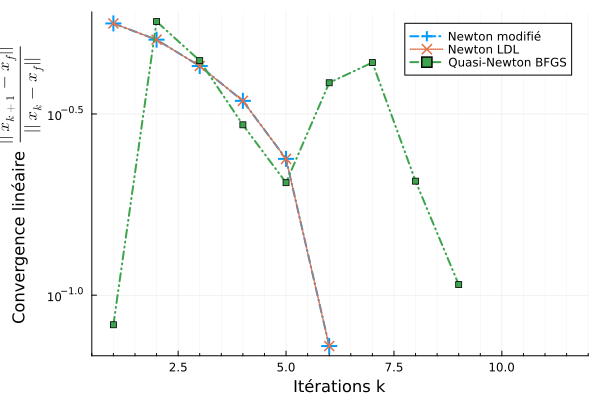

In [29]:
xNM, yNM = convergenceLin(iterationsNM)
xLDL, yLDL = convergenceLin(iterationsLDL)
xBFGS, yBFGS = convergenceLin(iterationsBFGS)

# Plot with lines and markers for each dataset
plot(xNM, yNM, label="Newton modifié", marker=(8,:cross), line=(2,:dashdot))
plot!(xLDL, yLDL, label="Newton LDL", marker=(5,:x), line=(1.5,:dot))
plot!(xBFGS, yBFGS, label="Quasi-Newton BFGS", marker=(3,:square), line=(2,:auto))

# Other plot settings
plot!( yscale=:log10, minorgrid=true)
xlims!(0.5, 12)
#plot!(legend=:bottomright)
xlabel!("Itérations k")
ylabel!(L"Convergence linéaire $\frac{||x_{k+1}-x_f||}{||x_k-x_f||}$")

#### Graphique de convergence quadratique

On voit que les méthodes de Newton ne semblent diverger. Considérant l'échelle logarithmique, on pourrait dire que les valeurs sont relativement proche d'une itération à l'autre . On pourrait donc en déduire que l'ordre de convergence est un peu plus petit que 2, ce qui pourrait être dû à des erreurs numériques, au point initial choisi, etc.

On voit aussi que la méthode BFGS ne converge pas du tout à l'ordre 2. Ceci peu être dû au fait que le régime de convergence observé est instable et/ou au fait que la méthode BFGS converge à un ordre \\(p\\) entre 1 et 2.

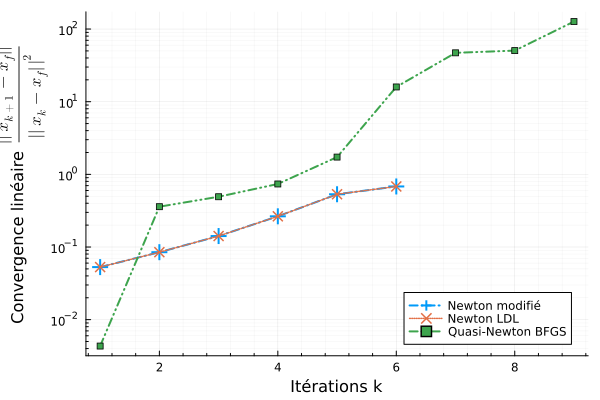

In [30]:
xNM, yNM = convergenceQuad(iterationsNM)
xLDL, yLDL = convergenceQuad(iterationsLDL)
xBFGS, yBFGS = convergenceQuad(iterationsBFGS)

# Plot with lines and markers for each dataset
plot(xNM, yNM, label="Newton modifié", marker=(8,:cross), line=(2,:dashdot))
plot!(xLDL, yLDL, label="Newton LDL", marker=(5,:x), line=(1.5,:dot))
plot!(xBFGS, yBFGS, label="Quasi-Newton BFGS", marker=(3,:square), line=(2,:auto))

# Other plot settings
plot!( yscale=:log10, minorgrid=true)
xlabel!("Itérations k")
plot!(legend=:bottomright)
ylabel!(L"Convergence linéaire $\frac{||x_{k+1}-x_f||}{||x_k-x_f||^2}$")